# 라이브러리 설치,import, 데이터 준비



In [ ]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install autocorrect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')

import re
from nltk.tokenize import word_tokenize
import wordcloud
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences #keras_preprocessing

from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split

import os 
import warnings
warnings.filterwarnings(action  = 'ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

from autocorrect import Speller 

In [ ]:
#%config Completer.use_jedi = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv('drive/MyDrive/AI4DL_project/train.csv')
df_test = pd.read_csv('drive/MyDrive/AI4DL_project/test.csv')
df_sample = pd.read_csv('drive/MyDrive/AI4DL_project/sample_submission.csv')

In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_train.shape

(7613, 5)

In [ ]:
df_test.shape

(3263, 4)

In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# EDA

In [ ]:
def create_corpus(target):
    corpus = []
    for x in df_train[df_train["target"] == target]["text"].str.split():
        print(x)
        for i in x:
            corpus.append(i)
            
    return corpus

In [ ]:
corpus = create_corpus(0)

stop = set(stopwords.words("english"))

dictionary = defaultdict(int)
for word in corpus:
    if word in stop:
        dictionary[word] +=1
        
top = sorted(dictionary.items(), key = lambda x:x[1], reverse=True)[:10]

Text(0.5, 1.0, 'top words 0')

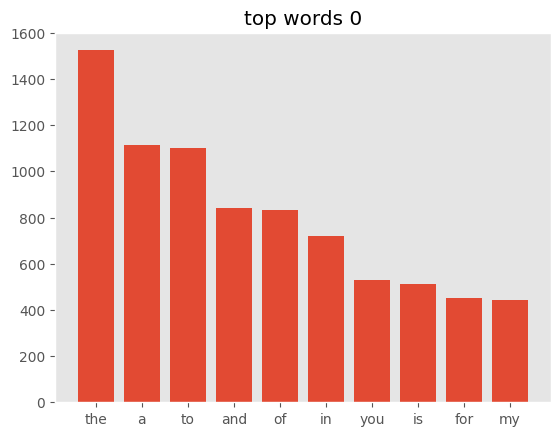

In [ ]:
x, y = zip(*top)

plt.grid()
plt.bar(x,y)
plt.title("top words 0")

In [ ]:
corpus = create_corpus(1)

stop = set(stopwords.words("english"))

dictionary = defaultdict(int)
for word in corpus:
    if word in stop:
        dictionary[word] +=1
        
top = sorted(dictionary.items(), key = lambda x:x[1], reverse=True)[:10]

Text(0.5, 1.0, 'top words 1')

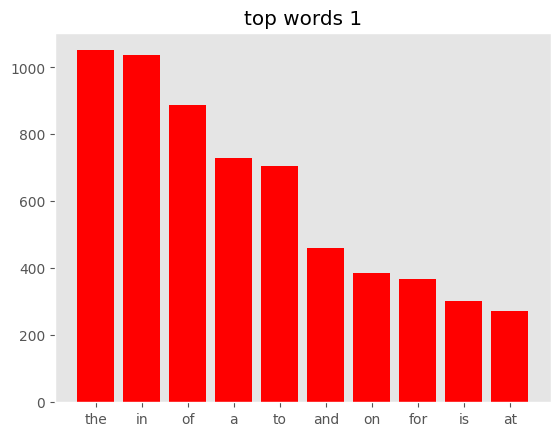

In [ ]:
x, y = zip(*top)

plt.grid()
plt.bar(x,y, color = 'r')
plt.title("top words 1")

In [ ]:
corpus = create_corpus(1)

dictionary = defaultdict(int)

import string

special_char = string.punctuation

for i in corpus:
    if i in special_char:
        dictionary[i] +=1

Text(0.5, 1.0, 'Punctuation disaster 1')

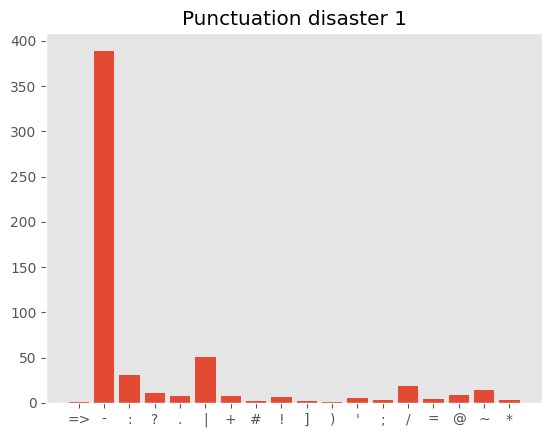

In [ ]:
x,y = zip(*dictionary.items())

plt.grid()
plt.bar(x,y)
plt.title("Punctuation disaster 1")

In [ ]:
corpus = create_corpus(0)

dictionary = defaultdict(int)

import string

special_char = string.punctuation

for i in corpus:
    if i in special_char:
        dictionary[i] +=1

Text(0.5, 1.0, 'Punctuation disaster 0')

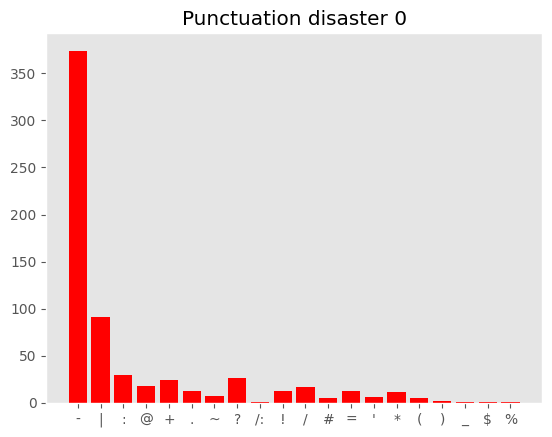

In [ ]:
x,y = zip(*dictionary.items())

plt.grid()
plt.bar(x,y, color = 'r')
plt.title("Punctuation disaster 0")

In [ ]:
counter = Counter(corpus)
most = counter.most_common()
x = []
y = []

for word, count in most[:40]:
    if word not in stop:
        x.append(word)
        y.append(count)

<Axes: title={'center': 'most common words'}>

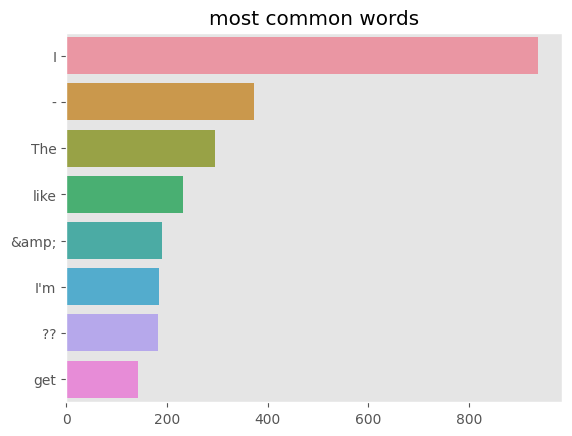

In [ ]:
plt.title("most common words")
plt.grid()
sns.barplot(x = y, y = x)

# 데이터 전처리

In [ ]:
import emoji

def text_preproccessing(df):  
    
    df = df.copy()
    
    def remove_URL(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)

    def remove_html(text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)

    def remove_punct(text):
        table=str.maketrans('','',string.punctuation)
        return text.translate(table)

    # Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
    def remove_emoji(text):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    def remove_stopwords(x):
        return ' '.join([i for i in x.split() if i not in wordcloud.STOPWORDS])

    def spell_check(x):
        spell = Speller(lang='en')
        return " ".join([spell(i) for i in x.split()])

    df['text']=df['text'].apply(lambda x : remove_URL(x))
    df['text']=df['text'].apply(lambda x : remove_html(x))
    df['text']=df['text'].apply(lambda x : remove_punct(x))
    df['text']=df['text'].apply(lambda x : remove_emoji(x))
    #df['text']=df['text'].apply(lambda x : remove_stopwords(x))
    #df['text']=df['text'].apply(lambda x : spell_check(x))

    return df


In [ ]:
df_train = text_preproccessing(df_train)
df_test = text_preproccessing(df_test)

In [ ]:
df_train.shape

(7613, 5)

In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1


In [ ]:
df_test.shape

(3263, 4)

In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,Heard about earthquake is different cities sta...
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
df=pd.concat([df_train,df_test])
df.shape

(10876, 5)

# GLOVE

In [ ]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [ ]:
corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:01<00:00, 8109.41it/s]


In [ ]:
from urllib.request import urlretrieve, urlopen
import gzip
import zipfile

#pre-trained word embedding download
urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="glove.6B.zip")
zf = zipfile.ZipFile('glove.6B.zip')
zf.extractall() 
zf.close()

In [ ]:
embedding_dict = dict()

f = open('glove.6B.100d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]

    #100개의 값을 가지는 array로 변환
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


In [ ]:
embedding_dict['described']
#임의의 단어의 임베딩 벡터

array([-0.77675  , -0.39544  , -0.23503  ,  0.12374  , -0.062412 ,
        0.16114  ,  0.41224  , -0.1183   , -0.24595  , -0.0042676,
       -0.46711  , -0.1773   ,  0.22936  , -0.15351  ,  0.19196  ,
        0.3456   ,  0.19291  , -0.48402  , -0.62981  , -0.05973  ,
        0.30394  , -0.20145  ,  0.12788  , -0.29756  ,  0.014653 ,
       -0.042935 , -0.097113 ,  0.043257 ,  0.02393  ,  0.73688  ,
        0.22381  ,  0.18879  , -0.30323  ,  0.012293 ,  0.29425  ,
        0.24309  ,  0.048583 ,  0.26707  , -0.056675 , -0.10544  ,
       -0.80896  ,  0.23054  ,  0.70457  ,  0.37263  , -0.036724 ,
       -0.23211  ,  0.12504  ,  0.044823 , -0.060565 , -0.14451  ,
        0.66952  , -0.42189  ,  0.94151  ,  0.78102  , -0.50328  ,
       -2.0984   , -0.18119  , -0.18671  ,  0.6576   ,  0.55676  ,
       -0.081965 ,  0.61956  , -0.18996  , -0.38323  ,  0.94778  ,
       -0.45197  ,  0.62815  ,  0.42958  ,  0.20367  ,  0.18164  ,
       -0.2055   ,  0.35146  , -0.19534  , -0.034256 ,  0.2947

In [ ]:
print('벡터의 차원 수 :',len(embedding_dict['described']))

벡터의 차원 수 : 100


In [ ]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)

sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [ ]:
tweet_pad

array([[ 622, 5467,  738, ...,    0,    0,    0],
       [  96,    7,  138, ...,    0,    0,    0],
       [ 119, 1469, 1386, ...,    0,    0,    0],
       ...,
       [ 749,  478,  348, ...,    0,    0,    0],
       [4085,  536,  372, ...,    0,    0,    0],
       [3997, 2557, 1462, ...,    0,    0,    0]], dtype=int32)

In [ ]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


In [ ]:
num_words=len(word_index)

In [ ]:
embedding_matrix = np.zeros((num_words, 100))

In [ ]:
len(word_index.items())

20342

In [ ]:
for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 20342/20342 [00:00<00:00, 296678.32it/s]


In [ ]:
embedding_matrix.shape

(20342, 100)

In [ ]:
tweet_pad[0][0:]

array([ 622, 5467,  738,  175,   80, 1805, 3529,   16,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
model=Sequential()

output_dim = 100
embedding=Embedding(num_words,output_dim,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

optimzer=Adam(learning_rate=1e-5)

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=5                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    )
]

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           2034200   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,076,505
Trainable params: 42,305
Non-trainable params: 2,034,200
_________________________________________________________________


In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(tweet_pad[:df_train.shape[0]], df_train['target'].values, test_size=0.15, random_state=10)

print('Shape of train',train_data.shape)
print("Shape of Validation ",val_data.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [ ]:
train_history = model.fit(
    train_data, train_labels,
    validation_data = (val_data, val_labels),
    callbacks=callbacks_list,
    #validation_split = 0.1,
    epochs=30,
    batch_size=4
)

Epoch 1/30
1618/1618 [==============================] - ETA: 0s - loss: 0.6891 - accuracy: 0.5733
Epoch 1: val_accuracy improved from -inf to 0.55604, saving model to checkpoint_path.keras
1618/1618 [==============================] - 52s 30ms/step - loss: 0.6891 - accuracy: 0.5733 - val_loss: 0.6659 - val_accuracy: 0.5560
Epoch 2/30
1618/1618 [==============================] - ETA: 0s - loss: 0.5722 - accuracy: 0.7231
Epoch 2: val_accuracy improved from 0.55604 to 0.77496, saving model to checkpoint_path.keras
1618/1618 [==============================] - 49s 31ms/step - loss: 0.5722 - accuracy: 0.7231 - val_loss: 0.5276 - val_accuracy: 0.7750
Epoch 3/30
1618/1618 [==============================] - ETA: 0s - loss: 0.5330 - accuracy: 0.7565
Epoch 3: val_accuracy improved from 0.77496 to 0.77671, saving model to checkpoint_path.keras
1618/1618 [==============================] - 54s 33ms/step - loss: 0.5330 - accuracy: 0.7565 - val_loss: 0.5033 - val_accuracy: 0.7767
Epoch 4/30
1617/1618 [

KeyboardInterrupt: ignored

In [ ]:
loaded_model = tf.keras.models.load_model('checkpoint_path.keras')

In [ ]:
predicted = loaded_model.predict(tweet_pad[df_train.shape[0]:])

In [ ]:
y_predicted = np.where(predicted>0.5,1,0)
y_predicted = y_predicted.reshape((1,3263))[0]
df_sample['id'] = df_test.id
df_sample['target'] = y_predicted
df_sample.to_csv('submission.csv',index = False)

리더보드 결과 : 0.79098

# RNN

In [ ]:
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,ariaahrary TheTawniest The out of control wild...,1
7610,10871,NaN,NaN,M194 0104 UTC5km S of Volcano Hawaii,1
7611,10872,NaN,NaN,Police investigating after an ebike collided w...,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train['text'], df_train['target'], test_size=0.2, random_state=0, stratify=df_train['target'].values)

In [ ]:
print('--------훈련 데이터의 비율-----------')
print(f'재난X = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'재난0 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
재난X = 57.028%
재난0 = 42.972%


In [ ]:
print('--------테스트 데이터의 비율-----------')
print(f'재난X = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'재난O = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')

--------테스트 데이터의 비율-----------
재난X = 57.058%
재난O = 42.942%


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
print(X_train_encoded[:5])

[[286, 2, 41, 3, 1, 5783, 322, 1120, 359, 18, 1217, 619, 66, 15, 2005], [5784, 5785, 5786, 36, 99, 3825, 1323, 266, 245], [5787, 5788, 1121, 85, 585], [6, 127, 7, 23, 5789, 52, 1324, 924, 3, 41, 5790, 2366, 35, 1759, 5791, 38, 22, 2, 5792, 2006, 205, 11, 142, 1122, 239], [5793, 86, 3826, 3827, 5794, 1576, 18, 26, 3, 749, 5795, 1218, 30, 232, 380, 78, 90, 6, 704, 2923, 217, 23, 705, 167]]


In [ ]:
word_to_index = tokenizer.word_index
print(word_to_index)

{'the': 1, 'a': 2, 'in': 3, 'to': 4, 'of': 5, 'and': 6, 'i': 7, 'is': 8, 'for': 9, 'on': 10, 'you': 11, 'my': 12, 'that': 13, 'with': 14, 'it': 15, 'at': 16, 'by': 17, 'this': 18, 'from': 19, 'be': 20, 'are': 21, 'have': 22, 'was': 23, 'as': 24, 'like': 25, 'up': 26, 'but': 27, 'me': 28, 'just': 29, 'amp': 30, 'im': 31, 'so': 32, 'your': 33, 'not': 34, 'out': 35, 'after': 36, 'has': 37, 'will': 38, 'all': 39, 'its': 40, 'fire': 41, 'no': 42, 'if': 43, 'we': 44, 'when': 45, 'an': 46, 'more': 47, 'get': 48, 'now': 49, 'via': 50, 'new': 51, 'about': 52, 'news': 53, 'what': 54, 'dont': 55, 'been': 56, 'or': 57, 'he': 58, 'one': 59, 'people': 60, 'how': 61, 'they': 62, 'over': 63, 'who': 64, 'were': 65, 'do': 66, 'can': 67, 'us': 68, 'video': 69, 'into': 70, '2': 71, 'there': 72, 'disaster': 73, 'emergency': 74, 'than': 75, 'some': 76, 'police': 77, 'her': 78, 'his': 79, 'would': 80, 'still': 81, 'storm': 82, 'crash': 83, 'why': 84, 'body': 85, 'time': 86, 'suicide': 87, 'burning': 88, 'bui

In [ ]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 1인 것들 개수 카운트
total_freq = 0 # 훈련 데이터 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 1인 것들의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 9951
단어 집합(vocabulary)에서 희귀 단어의 비율: 63.24922138180894
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 11.642000584966365


In [ ]:
# 한번만 나오는 단어 제거!!!
tokenizer = Tokenizer(num_words = total_cnt - rare_cnt + 1)

In [ ]:
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 15734


In [ ]:
print('메일의 최대 길이 : %d' % max(len(sample) for sample in X_train_encoded))
print('메일의 평균 길이 : %f' % (sum(map(len, X_train_encoded))/len(X_train_encoded)))

메일의 최대 길이 : 31
메일의 평균 길이 : 14.035304


In [ ]:
max_len = 189
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len)     # padding
print("훈련 데이터의 크기(shape):", X_train_padded.shape)

훈련 데이터의 크기(shape): (6090, 189)


In [ ]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

embedding_dim = 32
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=BinaryAccuracy('accuracy'))

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=2                                 
    ) 
    ]

history = model.fit(X_train_padded, y_train, epochs=20, batch_size=64, callbacks = callbacks_list, validation_split=0.2)

Epoch 1/20
77/77 [==============================] - 24s 287ms/step - loss: 0.6417 - accuracy: 0.6344 - val_loss: 0.5592 - val_accuracy: 0.7282
Epoch 2/20
77/77 [==============================] - 17s 223ms/step - loss: 0.4655 - accuracy: 0.7943 - val_loss: 0.5392 - val_accuracy: 0.7151
Epoch 3/20
77/77 [==============================] - 19s 244ms/step - loss: 0.3290 - accuracy: 0.8690 - val_loss: 0.5556 - val_accuracy: 0.7455
Epoch 4/20
77/77 [==============================] - 17s 218ms/step - loss: 0.2747 - accuracy: 0.8898 - val_loss: 0.5359 - val_accuracy: 0.7471
Epoch 5/20
77/77 [==============================] - 17s 219ms/step - loss: 0.1748 - accuracy: 0.9368 - val_loss: 0.5218 - val_accuracy: 0.7775
Epoch 6/20
77/77 [==============================] - 16s 214ms/step - loss: 0.1345 - accuracy: 0.9548 - val_loss: 0.5820 - val_accuracy: 0.7430
Epoch 7/20
77/77 [==============================] - 18s 233ms/step - loss: 0.0993 - accuracy: 0.9682 - val_loss: 0.6643 - val_accuracy: 0.7299

# LSTM

In [ ]:
df.dropna(subset = ['text'], inplace = True)

X = df['text']
y = df['target']

In [ ]:
# Nan 제거
nan_indices = np.isnan(y)
X = X[~nan_indices]
y = y[~nan_indices]

In [ ]:
def get_model():
    model = tf.keras.Sequential([
        Input(name='inputs',shape=[MAX_LEN]),
        Embedding(len(tok.word_index), 128),
        Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
        Bidirectional(tf.keras.layers.LSTM(64)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])
    
    return model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 0)

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout


MAX_LEN = 50

tok = Tokenizer()
tok.fit_on_texts(X_train)

sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

X_train_seq = pad_sequences(sequences,maxlen=MAX_LEN)
X_test_seq = pad_sequences(test_sequences,maxlen=MAX_LEN)


model = get_model()

history = model.fit(X_train_seq, y_train, 
                    epochs=50, validation_split = 0.2, batch_size = 32, 
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=6, verbose=False,restore_best_weights=True)])

Epoch 1/50
153/153 [==============================] - 29s 126ms/step - loss: 0.6844 - accuracy: 0.5606 - val_loss: 0.6680 - val_accuracy: 0.5961
Epoch 2/50
153/153 [==============================] - 7s 41ms/step - loss: 0.6137 - accuracy: 0.6677 - val_loss: 0.5036 - val_accuracy: 0.7726
Epoch 3/50
153/153 [==============================] - 5s 33ms/step - loss: 0.3668 - accuracy: 0.8487 - val_loss: 0.5052 - val_accuracy: 0.7849
Epoch 4/50
153/153 [==============================] - 3s 22ms/step - loss: 0.2427 - accuracy: 0.9146 - val_loss: 0.5536 - val_accuracy: 0.7890
Epoch 5/50
153/153 [==============================] - 5s 31ms/step - loss: 0.1510 - accuracy: 0.9497 - val_loss: 0.6226 - val_accuracy: 0.7586
Epoch 6/50
153/153 [==============================] - 4s 25ms/step - loss: 0.1121 - accuracy: 0.9680 - val_loss: 0.7070 - val_accuracy: 0.7923
Epoch 7/50
153/153 [==============================] - 3s 18ms/step - loss: 0.0860 - accuracy: 0.9752 - val_loss: 0.8537 - val_accuracy: 0.74

# ELMO

# BERT

In [ ]:
max_length = max([len(sent.split()) for sent in df_train.text ])
print(max_length)

31


In [ ]:
max_length = max([len(sent.split()) for sent in df_test.text ])
print(max_length)

31


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 97.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.7 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(df_train.text.values, df_train.target.values, test_size=0.2, random_state=10)

In [ ]:
train_data = tokenizer(
text = train_data.tolist(),
    add_special_tokens = True,
    max_length = 34,
    truncation = True,
    padding = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
    
)

In [ ]:
train_data

{'input_ids': <tf.Tensor: shape=(6090, 34), dtype=int32, numpy=
array([[  101,  5796,  4328, ...,     0,     0,     0],
       [  101,  8026, 14887, ...,     0,     0,     0],
       [  101,  3963,  2086, ...,     0,     0,     0],
       ...,
       [  101,  5043,  2007, ...,     0,     0,     0],
       [  101,  2663,  5622, ...,     0,     0,     0],
       [  101,  5506,  2314, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(6090, 34), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
val_data = tokenizer(
text = val_data.tolist(),
    add_special_tokens = True,
    max_length = 34,
    truncation = True,
    padding = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
    
)

##Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [ ]:
max_len = 34


input_ids = keras.Input(shape = (max_len,), dtype = tf.int32, name = 'input_ids')
input_mask = keras.Input(shape = (max_len,), dtype = tf.int32, name = 'input_mask')

embeddings = bert([input_ids, input_mask])[1]

out = tf.keras.layers.Dropout(0.1)(embeddings)

out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [ ]:
model.summary()

In [ ]:
train_data['input_ids']

In [ ]:
from keras.optimizers import Adam
optimizer = Adam(
    learning_rate=6e-06, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy')


model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=2                                 
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    )
]

In [ ]:
train_history = model.fit(
    x ={'input_ids':train_data['input_ids'],'input_mask':train_data['attention_mask']} ,
    y = train_labels,
    validation_data = ({'input_ids':val_data['input_ids'],'input_mask':val_data['attention_mask']},val_labels),
    callbacks=callbacks_list,
    #validation_split = 0.1,
    epochs=20,
    batch_size=10
)

IndexError: ignored

In [ ]:
loaded_model = tf.keras.models.load_model('checkpoint_path.keras', custom_objects={"TFBertModel": TFBertModel})

In [ ]:
x_test = tokenizer(
    text=df_test.text.tolist(),
    add_special_tokens=True,
    max_length=34,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

TypeError: ignored

In [ ]:
x_test['attention_mask']

In [ ]:
predicted = loaded_model.predict({'input_ids':x_test['input_ids'],'input_mask':x_test['attention_mask']})

NameError: ignored

In [ ]:
y_predicted = np.where(predicted>0.5,1,0)
y_predicted = y_predicted.reshape((1,3263))[0]
df_sample['id'] = df_test.id
df_sample['target'] = y_predicted
df_sample.to_csv('submission.csv',index = False)

# 리더보드 0.82929

# BERTweet